In [135]:
import numpy as np
import pandas as pd

from sklearn.model_selection import train_test_split, StratifiedKFold, cross_val_score
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline

from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import (
    RandomForestClassifier,
    VotingClassifier,
    BaggingClassifier,
    GradientBoostingClassifier,
    StackingClassifier,
)

from sklearn.metrics import accuracy_score, f1_score, classification_report, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

In [136]:
from ucimlrepo import fetch_ucirepo

# fetch dataset
estimation_of_obesity_levels_based_on_eating_habits_and_physical_condition = fetch_ucirepo(id=544)

# data (as pandas dataframes)
X = estimation_of_obesity_levels_based_on_eating_habits_and_physical_condition.data.features
y = estimation_of_obesity_levels_based_on_eating_habits_and_physical_condition.data.targets

df = X.join(y)
df

,Gender,Age,Height,Weight,family_history_with_overweight,FAVC,FCVC,NCP,CAEC,SMOKE,CH2O,SCC,FAF,TUE,CALC,MTRANS,NObeyesdad
0,Female,21.000000,1.620000,64.000000,yes,no,2.0,3.0,Sometimes,no,2.000000,no,0.000000,1.000000,no,Public_Transportation,Normal_Weight
1,Female,21.000000,1.520000,56.000000,yes,no,3.0,3.0,Sometimes,yes,3.000000,yes,3.000000,0.000000,Sometimes,Public_Transportation,Normal_Weight
2,Male,23.000000,1.800000,77.000000,yes,no,2.0,3.0,Sometimes,no,2.000000,no,2.000000,1.000000,Frequently,Public_Transportation,Normal_Weight
3,Male,27.000000,1.800000,87.000000,no,no,3.0,3.0,Sometimes,no,2.000000,no,2.000000,0.000000,Frequently,Walking,Overweight_Level_I
4,Male,22.000000,1.780000,89.800000,no,no,2.0,1.0,Sometimes,no,2.000000,no,0.000000,0.000000,Sometimes,Public_Transportation,Overweight_Level_II
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2106,Female,20.976842,1.710730,131.408528,yes,yes,3.0,3.0,Sometimes,no,1.728139,no,1.676269,0.906247,Sometimes,Public_Transportation,Obesity_Type_III
2107,Female,21.982942,1.748584,133.742943,yes,yes,3.0,3.0,Sometimes,no,2.005130,no,1.341390,0.599270,Sometimes,Public_Transportation,Obesity_Type_III
2108,Female,22.524036,1.752206,133.689352,yes,yes,3.0,3.0,Sometimes,no,2.054193,no,1.414209,0.646288,Sometimes,Public_Transportation,Obesity_Type_III
2109,Female,24.361936,1.739450,133.346641,yes,yes,3.0,3.0,Sometimes,no,2.852339,no,1.139107,0.586035,Sometimes,Public_Transportation,Obesity_Type_III


In [137]:
X = df.drop("NObeyesdad", axis=1)
y = df["NObeyesdad"]

In [138]:
num_features = X.select_dtypes(include=["int64", "float64"]).columns
cat_features = X.select_dtypes(include=["object"]).columns

In [139]:
preprocessor = ColumnTransformer(
    transformers=[
        ("num", StandardScaler(), num_features),
        ("cat", OneHotEncoder(handle_unknown="ignore"), cat_features)
    ]
)

In [140]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y,
    test_size=0.2,
    random_state=42,
    stratify=y
)

In [141]:
models = {
    "lr": LogisticRegression(max_iter=2000),
    "rf": RandomForestClassifier(n_estimators=200, random_state=42),
    "knn": KNeighborsClassifier()
}

In [142]:
def train_model(model, X_train, X_test, y_train, y_test):
    pipe = Pipeline([
        ("prep", preprocessor),
        ("model", model)
    ])

    pipe.fit(X_train, y_train)
    y_pred = pipe.predict(X_test)

    acc = accuracy_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred, average="macro")

    return pipe, round(acc, 2), round(f1, 2)

In [143]:
results = {}

for name, model in models.items():
    pipe, acc, f1 = train_model(model, X_train, X_test, y_train, y_test)
    results[name] = {"Accuracy": acc, "F1_macro": f1}

results

{'lr': {'Accuracy': 0.87, 'F1_macro': 0.87},
 'rf': {'Accuracy': 0.94, 'F1_macro': 0.94},
 'knn': {'Accuracy': 0.83, 'F1_macro': 0.81}}

In [144]:
voting = VotingClassifier(
    estimators=[
        ("lr", models["lr"]),
        ("rf", models["rf"]),
        ("knn", models["knn"])
    ],
    voting="soft"
)

_, acc_v, f1_v = train_model(voting, X_train, X_test, y_train, y_test)
results["voting"] = {"Accuracy": acc_v, "F1_macro": f1_v}

In [145]:
bagging = BaggingClassifier(
    estimator=models["lr"],
    n_estimators=50,
    random_state=42
)

_, acc_b, f1_b = train_model(bagging, X_train, X_test, y_train, y_test)
results["bagging"] = {"Accuracy": acc_b, "F1_macro": f1_b}

In [146]:
boosting = GradientBoostingClassifier(random_state=42)

_, acc_boost, f1_boost = train_model(
    boosting,
    X_train,
    X_test,
    y_train,
    y_test
)

results["boosting"] = {"Accuracy": acc_boost, "F1_macro": f1_boost}

In [147]:
stacking = StackingClassifier(
    estimators=[
        ("lr", models["lr"]),
        ("rf", models["rf"]),
        ("knn", models["knn"])
    ],
    final_estimator=LogisticRegression(max_iter=2000)
)

_, acc_s, f1_s = train_model(stacking, X_train, X_test, y_train, y_test)
results["stacking"] = {"Accuracy": acc_s, "F1_macro": f1_s}

In [148]:
results

{'lr': {'Accuracy': 0.87, 'F1_macro': 0.87},
 'rf': {'Accuracy': 0.94, 'F1_macro': 0.94},
 'knn': {'Accuracy': 0.83, 'F1_macro': 0.81},
 'voting': {'Accuracy': 0.91, 'F1_macro': 0.91},
 'bagging': {'Accuracy': 0.86, 'F1_macro': 0.86},
 'boosting': {'Accuracy': 0.95, 'F1_macro': 0.95},
 'stacking': {'Accuracy': 0.94, 'F1_macro': 0.94}}

In [149]:
pd.DataFrame(results).T.sort_values("F1_macro", ascending=False)

,Accuracy,F1_macro
boosting,0.95,0.95
rf,0.94,0.94
stacking,0.94,0.94
voting,0.91,0.91
lr,0.87,0.87
bagging,0.86,0.86
knn,0.83,0.81


In [150]:
def cross_validate_model(model, X, y, cv=5):
    pipe = Pipeline([
        ("prep", preprocessor),
        ("model", model)
    ])

    skf = StratifiedKFold(n_splits=cv, shuffle=True, random_state=42)

    scores = cross_val_score(
        pipe,
        X,
        y,
        cv=skf,
        scoring="f1_macro"
    )

    return round(scores.mean(), 3), round(scores.std(), 3)

In [151]:
mean_f1, std_f1 = cross_validate_model(
    GradientBoostingClassifier(random_state=42),
    X,
    y
)

print("Boosting CV F1_macro:", mean_f1)
print("Std:", std_f1)

Boosting CV F1_macro: 0.956
Std: 0.008


In [152]:
best_model = Pipeline([
    ("prep", preprocessor),
    ("model", GradientBoostingClassifier(random_state=42))
])

best_model.fit(X_train, y_train)
y_pred = best_model.predict(X_test)

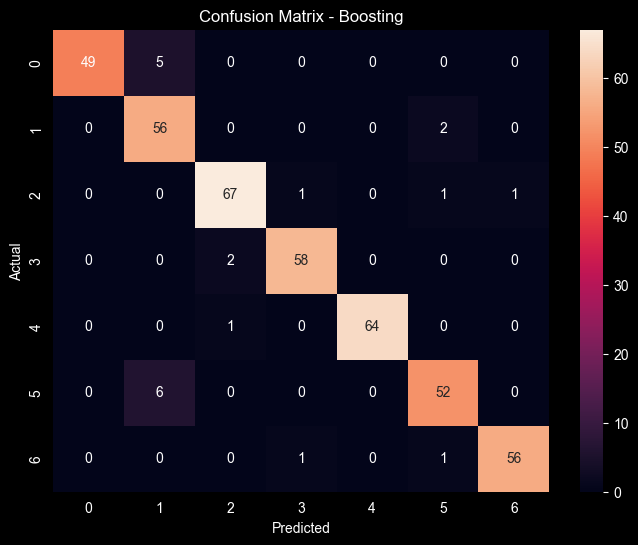

In [153]:
cm = confusion_matrix(y_test, y_pred)

plt.figure(figsize=(8,6))
sns.heatmap(cm, annot=True, fmt="d")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix - Boosting")
plt.show()